In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
# !pip install tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# !pip install scikit-learn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import shutil
import pandas as pd
from scipy.spatial import distance
import matplotlib.image as mpimg


2024-06-15 17:21:29.479441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define Necesseary Functions and Variables 

In [2]:
n_components_threshold = 0.40 ## percent variance that will be explained between componet PCAs

subcategories = [
    "process diagram",
    "2x2 matrix",
    "venn diagram",
    "conceptual diagram",
    "cycle",
    "hierarchical diagram",
    "bar chart",
    "stacked bar chart",
    "line graph",
    "scatter plot",
    "mixed statistical plot (more than 1 statistical plot type)",
    "data structure",
    "data collection, data analysis, data gathering diagrams",
    "heatmap",
    "data map",
    "organizational chart",
    "timeline",
    "drawing",
    "photo"
]

def load_and_preprocess_images(yearly_data, target_size=(224, 224)):
    image_paths = ["../" + figure_path for figure_path in yearly_data["new image path"]]
    images = [load_img(path, target_size=target_size) for path in image_paths]
    images_array = np.array([img_to_array(image) for image in images])
    images_array = preprocess_input(images_array)
    return images, images_array, image_paths

def extract_features(images_array):
    model = VGG16(weights='imagenet', include_top=False)
    features = model.predict(images_array)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

def reduce_dimensions(features, n_components=30):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features, pca

def perform_kmeans(reduced_features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_features)
    return labels, kmeans, reduced_features

def create_cluster_directories(base_dir, n_clusters):
    for i in range(0, n_clusters):
        path = os.path.join(base_dir, f'cluster_{i}')
        if not os.path.exists(path):
            os.makedirs(path)

def save_images_to_clusters(image_paths, labels, base_dir, n_clusters):
    for path, label in zip(image_paths, labels):
        directory = os.path.join(base_dir, f'cluster_{label}')
        shutil.copy(path, directory)

def visualize_clusters(reduced_features, labels, cluster_centers):
    plt.figure(figsize=(10, 6))
    # Use a colormap that provides up to 18 distinct colors. 'tab20' can provide up to 20 distinct colors.
    colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_centers)))
    for i in range(cluster_centers.shape[0]):
        plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')
    # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='yellow', marker='*', edgecolors='black', label='Centroids')
    plt.title('K-Means Clustering Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

def visualize_clusters_with_subcategories(reduced_features, labels, cluster_centers, subcategories):
    plt.figure(figsize=(10, 6))
    
    # Generate a color map for subcategories
    unique_subcategories = np.unique(subcategories)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_subcategories)))  # Using 'tab20' colormap for better color distinction
    color_map = {subcat: color for subcat, color in zip(unique_subcategories, colors)}
    
    # Plot each point
    for i, label in enumerate(labels):
        plt.scatter(reduced_features[i, 0], reduced_features[i, 1], color=color_map[subcategories[i]], label=subcategories[i] if subcategories[i] not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Plot centroids
    # plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='yellow', marker='*', edgecolors='black', label='Centroids')
    
    plt.title('Cluster Visualization by Subcategory')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def delete_all_subdirectories(base_dir):
    # Check if the base directory exists
    if not os.path.exists(base_dir):
        print("The specified directory does not exist.")
        return
    
    # Loop through each item in the base directory
    for item in os.listdir(base_dir):
        # Construct the full path to the item
        item_path = os.path.join(base_dir, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            # Remove the directory and all its contents
            shutil.rmtree(item_path)
            # print(f"Deleted {item_path}")


def get_closest_images(reduced_features, centers, image_paths):
    closest_images = {}
    for i, center in enumerate(centers):
        distances = distance.cdist([center], reduced_features, 'euclidean')[0]
        min_index = np.argmin(distances)
        closest_images[i] = image_paths[min_index]
    return closest_images


def get_image_variance(figure_data):
    '''Function to get image variance'''
    # Load and preprocess images
    images, images_array, image_paths = load_and_preprocess_images(figure_data)
    # Extract features
    features_flattened = extract_features(images_array)


    # Looking at explained variance - use to inform Number of Components
    pca = PCA().fit(features_flattened)

    # Plotting the cumulative variance
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')
    plt.grid(True)
    plt.show()    
    return features_flattened, pca, image_paths

def reduce_create_visualize_save_cluters(figure_data, features_flattened, image_paths, base_dir, pca, cluster_count=None):
    if cluster_count is None:
        cluster_count = len(figure_data['subcategory'].unique())  # Set the number of clusters here

    subcategories = figure_data['subcategory'].values

    # Looking at explained variance to inform the number of components
    n_components_above_threshold = np.where(np.cumsum(pca.explained_variance_ratio_) >= n_components_threshold)[0][0] + 1
    reduced_features, pca = reduce_dimensions(features_flattened, n_components=n_components_above_threshold)

    # Remove outliers from features and get the corresponding indices
    filtered_features, valid_indices = remove_outliers(reduced_features)
    filtered_image_paths = [image_paths[i] for i in range(len(image_paths)) if valid_indices[i]]
    filtered_subcategories = [subcategories[i] for i in range(len(subcategories)) if valid_indices[i]]

    print(f"n_clusters: {cluster_count}")
    print(f"n_components: {n_components_above_threshold}")

    # Perform KMeans clustering
    labels, kmeans, reduced_features = perform_kmeans(filtered_features, cluster_count)

    # Identify the closest image to each cluster center
    closest_images = get_closest_images(reduced_features, kmeans.cluster_centers_, filtered_image_paths)

    delete_all_subdirectories(base_dir)
    create_cluster_directories(base_dir, cluster_count)

    # Save images to their respective cluster directories
    save_images_to_clusters(filtered_image_paths, labels, base_dir, cluster_count)

    # Visualize K-Means Clusters
    visualize_clusters(reduced_features, labels, kmeans.cluster_centers_)
    # Now plot with subcategory coloring
    visualize_clusters_with_subcategories(reduced_features, labels, kmeans.cluster_centers_, filtered_subcategories)

    return labels, filtered_subcategories, closest_images


def save_representative_images(closest_images, base_dir):
    # Create a subdirectory for the most representative images
    target_dir = os.path.join(base_dir, "most_representative")
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop through each cluster and its corresponding closest image path
    for cluster, img_path in closest_images.items():
        # Extract the original image name
        image_name = os.path.basename(img_path)
        # Construct the new filename
        new_filename = f"cluster_{cluster}_{image_name}"
        # Create full path to the new file location
        new_file_path = os.path.join(target_dir, new_filename)
        # Copy the image to the new location with the new filename
        shutil.copy(img_path, new_file_path)
        # print(f"Saved {new_filename} to {target_dir}")
        
def display_closest_images(closest_images, base_dir):
    # Set the number of images per row
    n = len(closest_images)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))  # Adjust size as needed
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, (cluster, img_path) in enumerate(closest_images.items()):
        img = mpimg.imread(img_path)
        if n > 1:
            ax = axes[i]
        else:
            ax = axes  # If only one image, axes is not a list
        ax.imshow(img)
        ax.axis('off')  # Hide axes
        ax.set_title(f'Cluster {cluster}')

    plt.show()
    save_representative_images(closest_images, base_dir)


def remove_outliers(features, n_std_dev=4):
    """
    Remove points that are more than n_std_dev standard deviations
    from the mean of the dataset.
    """
    mean = np.mean(features, axis=0)
    std_dev = np.std(features, axis=0)
    distances = np.sqrt(np.sum((features - mean) ** 2, axis=1))
    threshold = n_std_dev * np.mean(std_dev)
    return features[distances < threshold], distances < threshold

## Load the yearly data

In [3]:
year = 2022  
file_path = f"../cropped_and_labeled_image_data/{year}_cropped_and_labeled_figs.xlsx"
yearly_figure_data = pd.read_excel(file_path)
print(f"Total figure count: {yearly_figure_data.shape[0]}")

Total figure count: 62


## Clustering for all types, except except drawing and photo


Total figure count, minus photos and drawings: 48
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


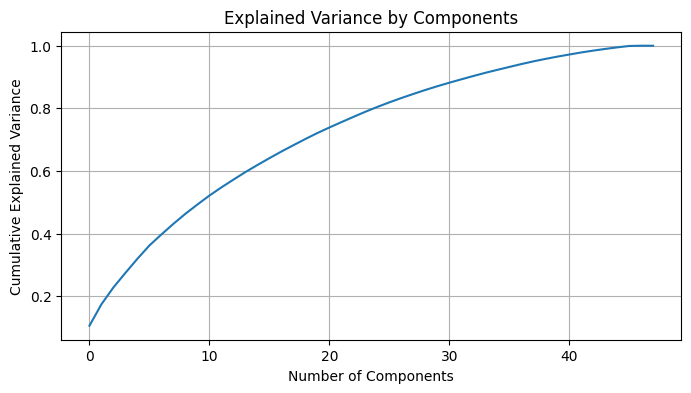

n_clusters: 8
n_components: 8


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_51877/2318763116.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')


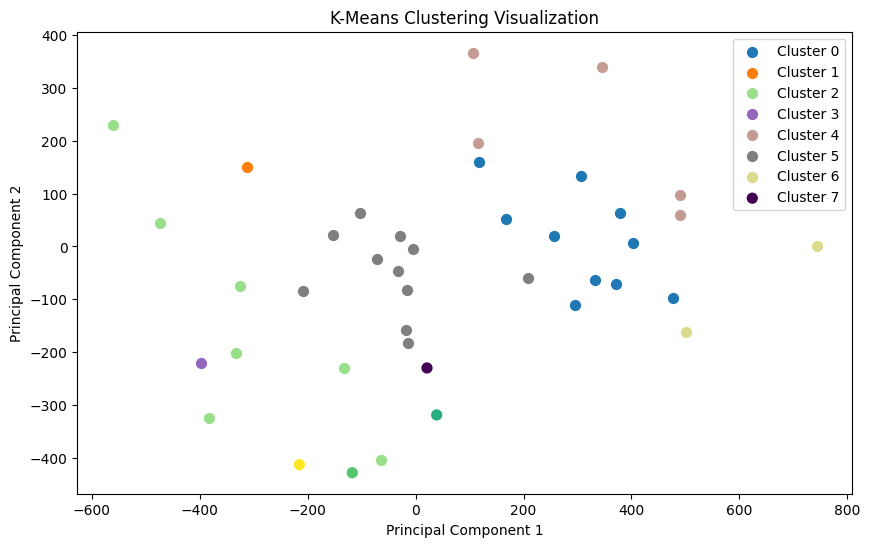

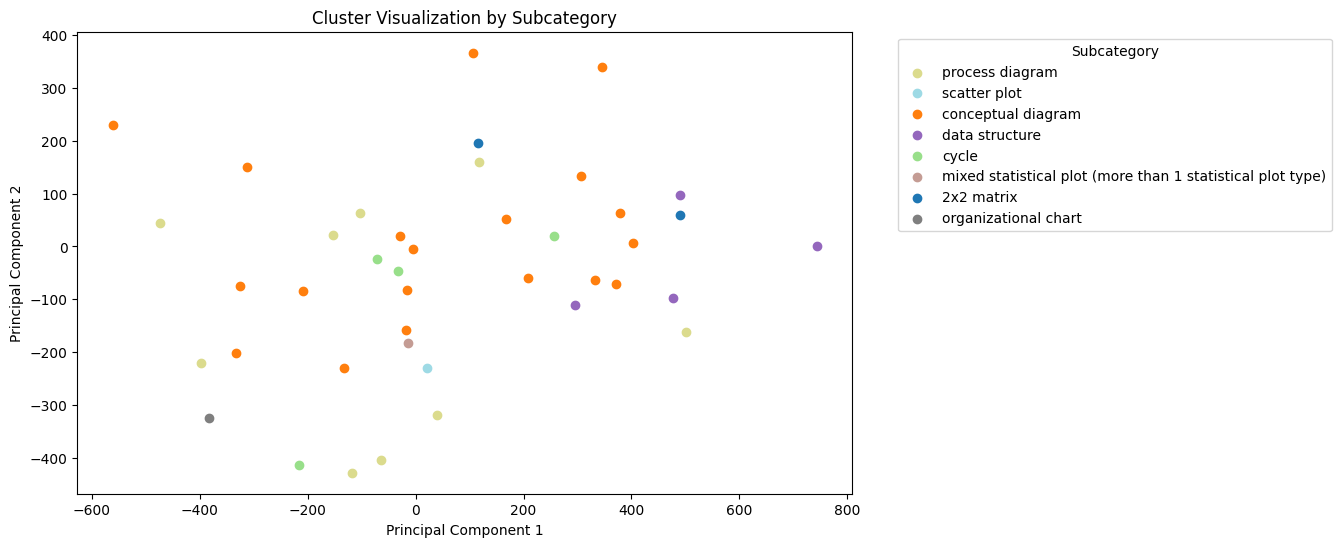

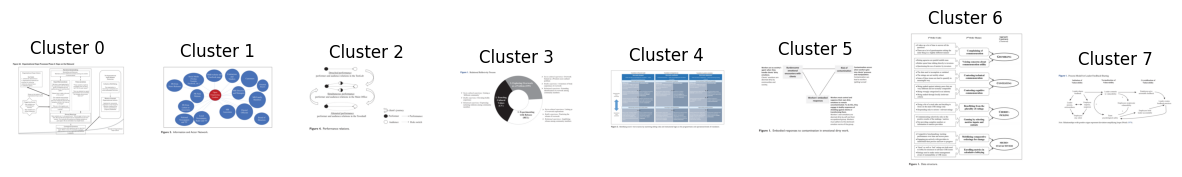

Subcategory,2x2 matrix,conceptual diagram,cycle,data structure,mixed statistical plot (more than 1 statistical plot type),organizational chart,process diagram,scatter plot
Cluster,,,,,,,,
0,0,6,1,2,0,0,1,0
1,0,1,0,0,0,0,0,0
2,0,4,0,0,0,1,2,0
3,0,0,0,0,0,0,1,0
4,2,2,0,1,0,0,0,0
5,0,6,2,0,1,0,2,0
6,0,0,0,1,0,0,1,0
7,0,0,1,0,0,0,2,1


In [4]:
## PCA Analyses
current_yearly_data = yearly_figure_data[~yearly_figure_data["subcategory"].isin(["photo", "drawing"])]
print(f"Total figure count, minus photos and drawings: {current_yearly_data.shape[0]}")
features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
# Create directories for clusters
base_dir = f'../clustered_images/{year}/no_photos_or_drawings'
labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca)
## display closest images
display_closest_images(closest_images, base_dir)
## Show counts of figure types in each cluster
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

## Clustering for those of type "diagram" 

Figure count in selected subcategories: 43
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


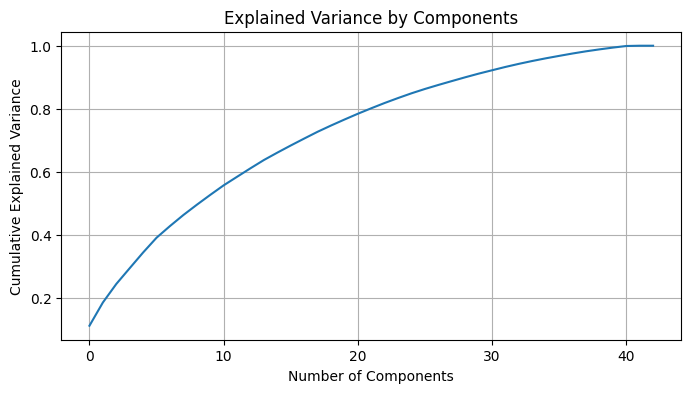

n_clusters: 4
n_components: 7


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_51877/2318763116.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')


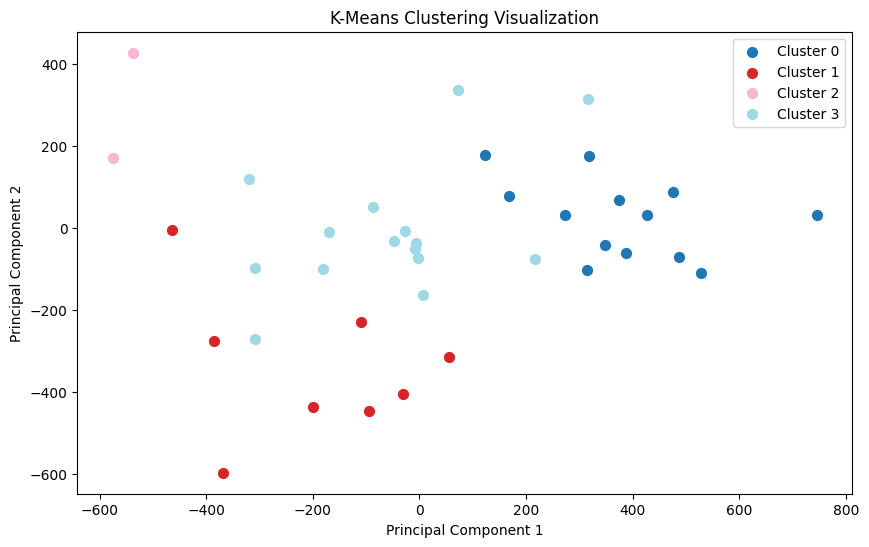

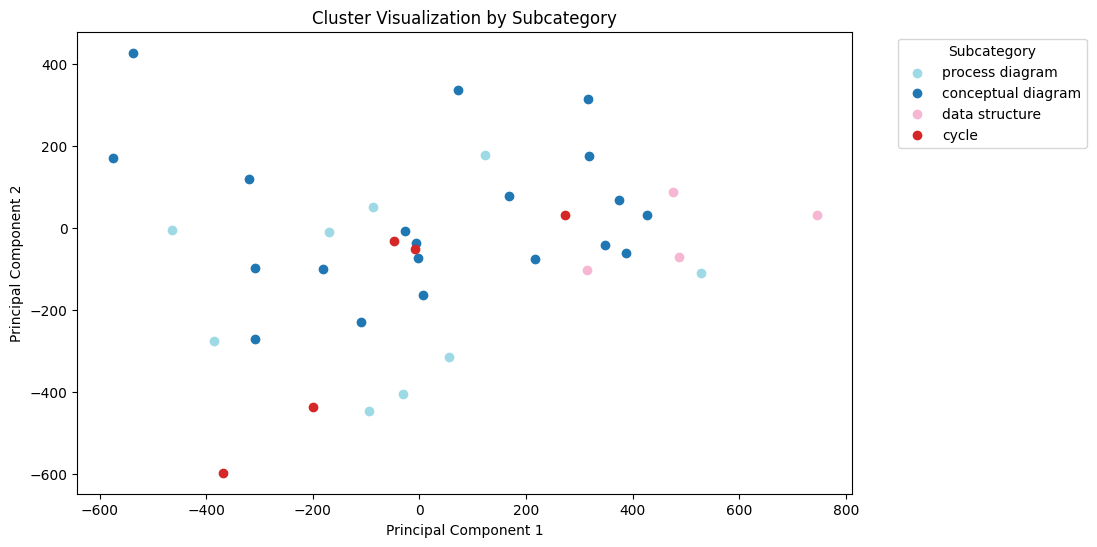

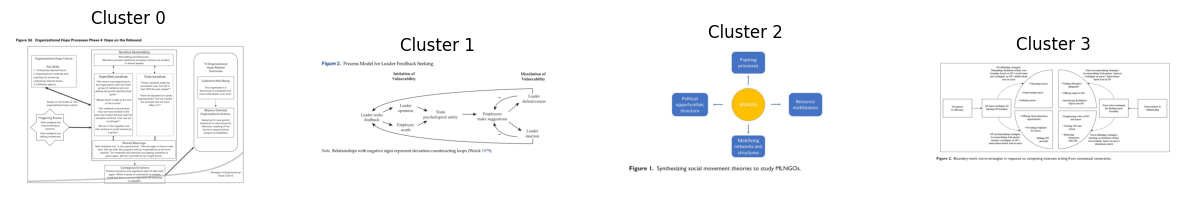

Subcategory,conceptual diagram,cycle,data structure,process diagram
Cluster,,,,
0,6,1,4,2
1,1,2,0,5
2,2,0,0,0
3,11,2,0,2


In [5]:
diagram_subcategories = [
   "process diagram",
    "conceptual diagram",
    "cycle",
    "hierarchical diagram",
    "data structure",
    "data collection, data analysis, data gathering diagrams"
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(diagram_subcategories)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
# Create directories for clusters
base_dir = f'../clustered_images/{year}/diagram_type'
labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca)
## display closest images
display_closest_images(closest_images, base_dir)
## Show counts of figure types in each cluster
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

## Clustering for only conceptual and process diagrams only

Figure count in selected subcategories: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


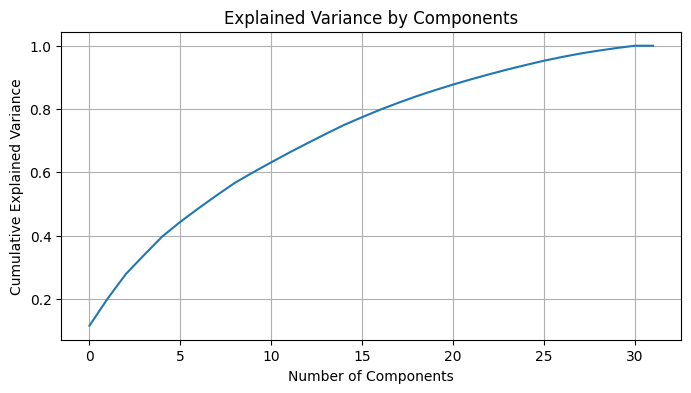

n_clusters: 4
n_components: 6


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_51877/2318763116.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')


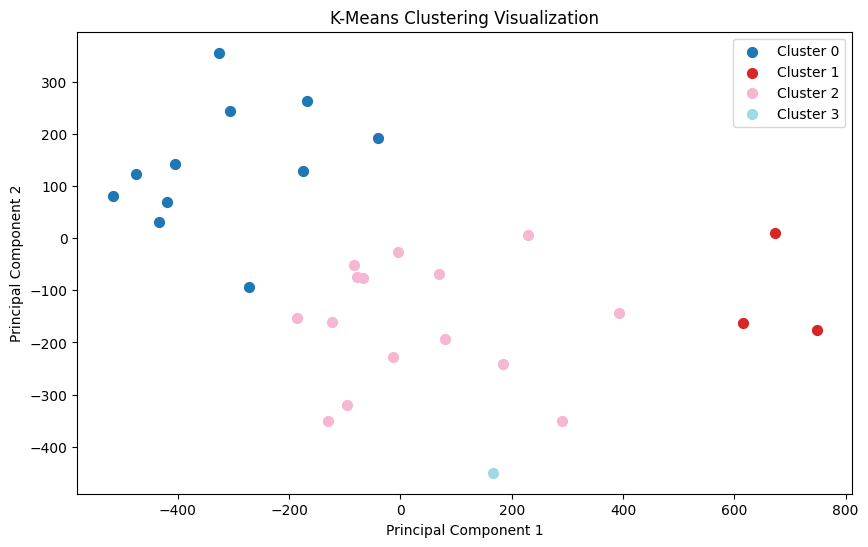

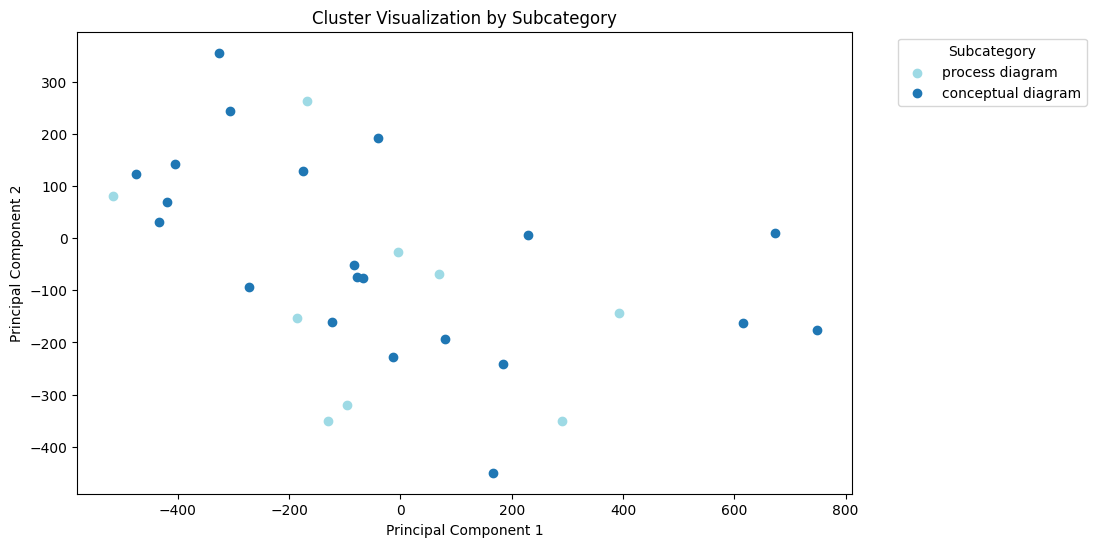

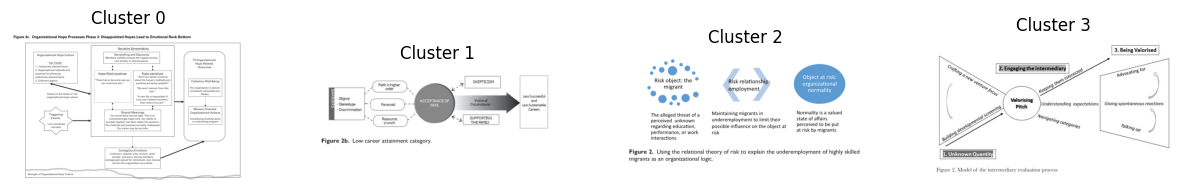

Subcategory,conceptual diagram,process diagram
Cluster,,
0,9,2
1,3,0
2,8,7
3,1,0


In [6]:
clustering_types = [
   "process diagram",
    "conceptual diagram",
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
# Create directories for clusters
base_dir = f'../clustered_images/{year}/process_and_conceptual'
labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca, cluster_count = 4)
## display closest images
display_closest_images(closest_images, base_dir)
## Show counts of figure types in each cluster
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

## Clustering for Process Diagram

Figure count in selected subcategories: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


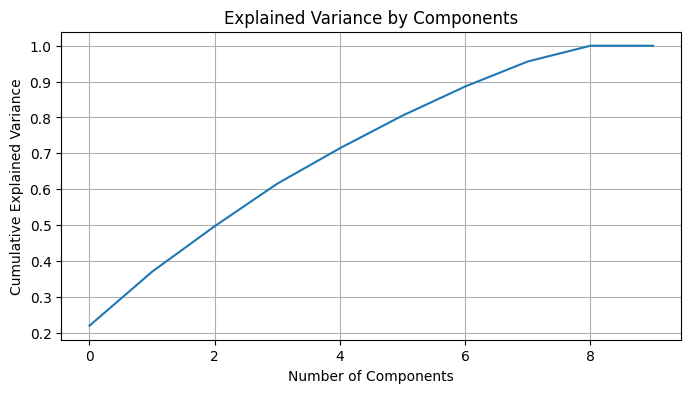

n_clusters: 1
n_components: 3


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_51877/2318763116.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')


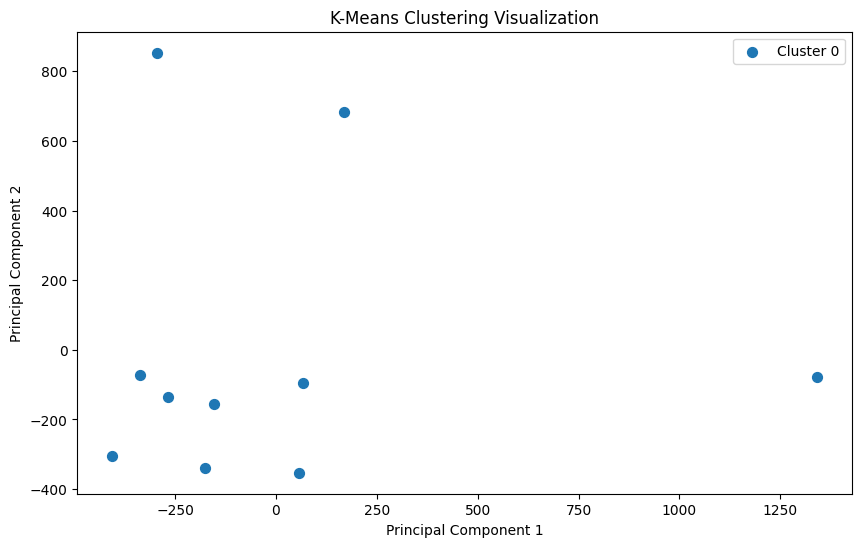

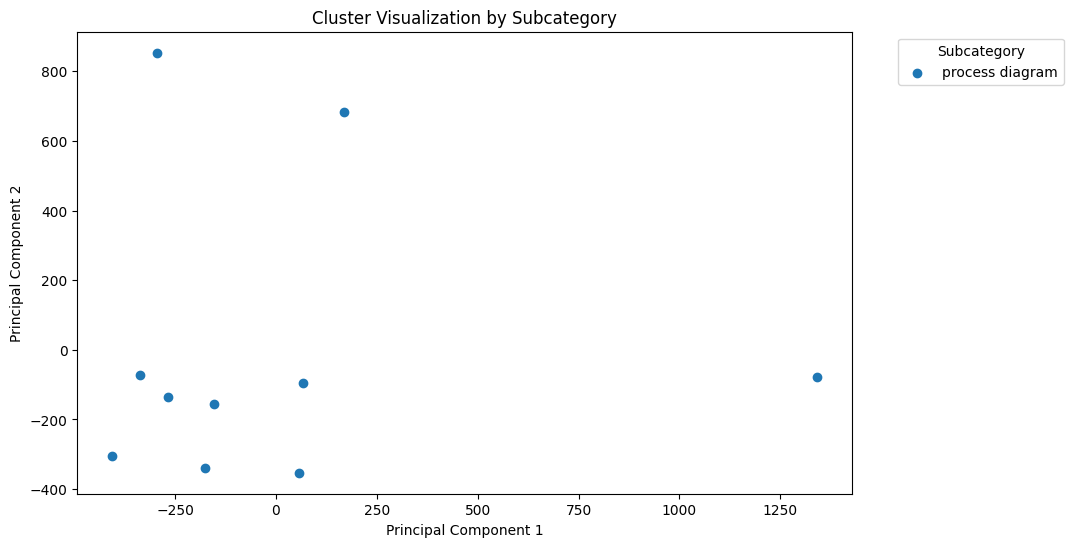

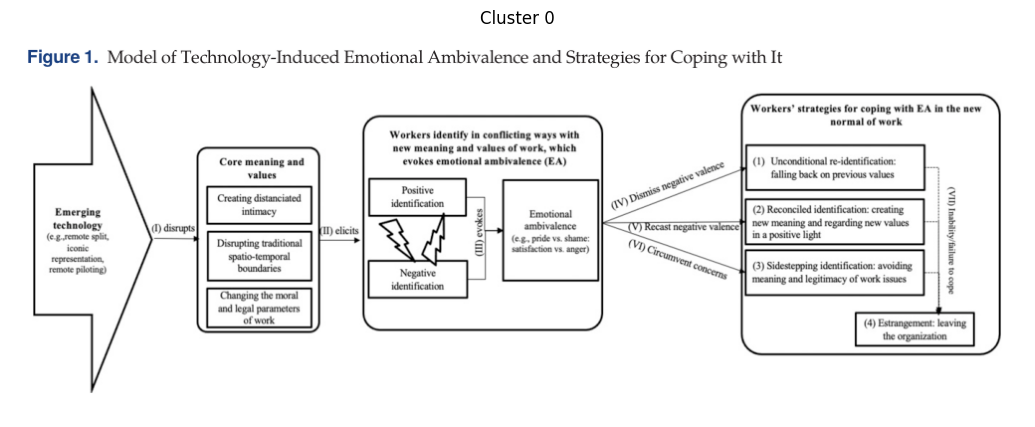

Subcategory,process diagram
Cluster,
0,10


In [7]:
clustering_types = [
   "process diagram",
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
# Create directories for clusters
base_dir = f'../clustered_images/{year}/process diagram'
labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca, cluster_count = 1)
## display closest images
display_closest_images(closest_images, base_dir)
## Show counts of figure types in each cluster
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

## Clustering for Conceptual Diagram

Figure count in selected subcategories: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


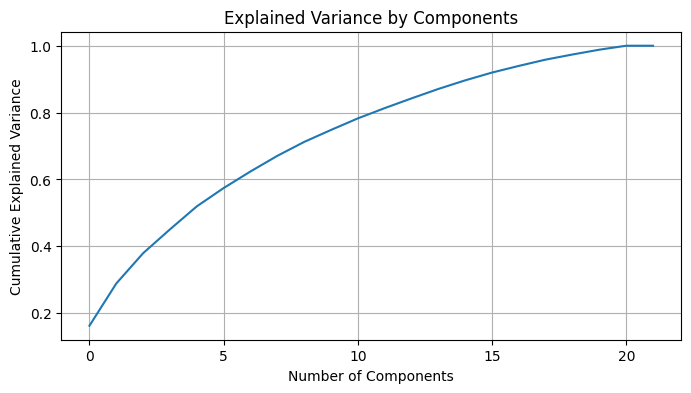

n_clusters: 1
n_components: 4


/var/folders/5b/4s4ttql508dccc90bhk9j9g80000gn/T/ipykernel_51877/2318763116.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')


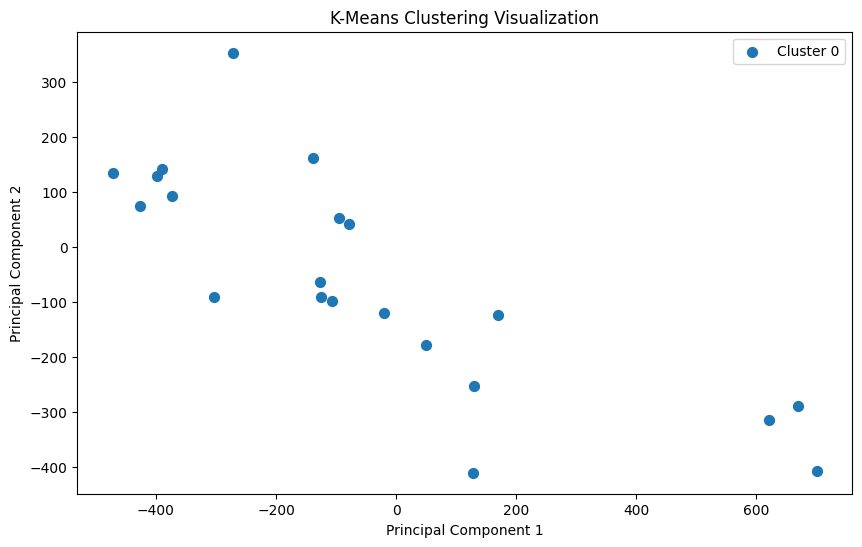

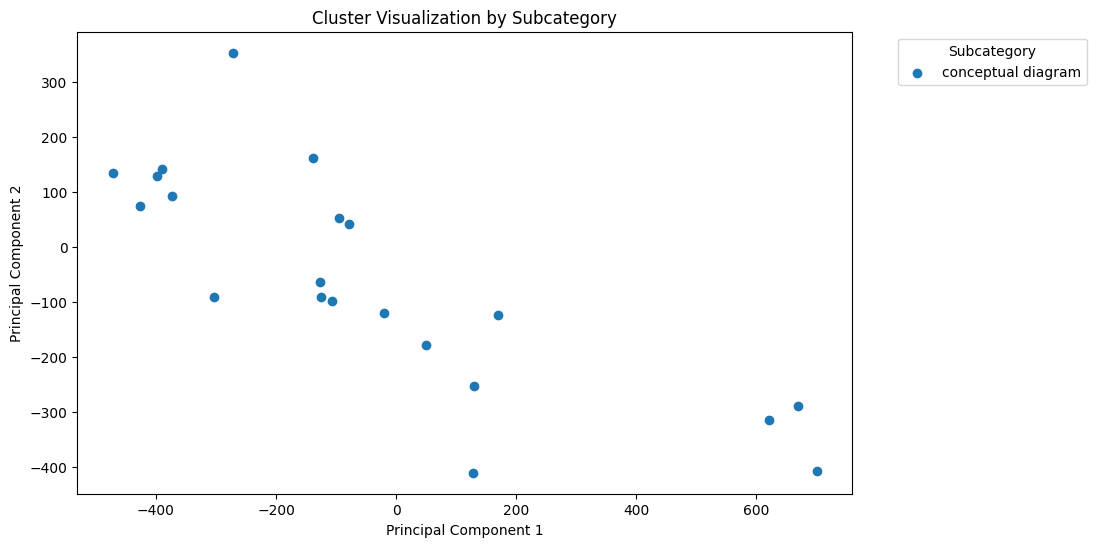

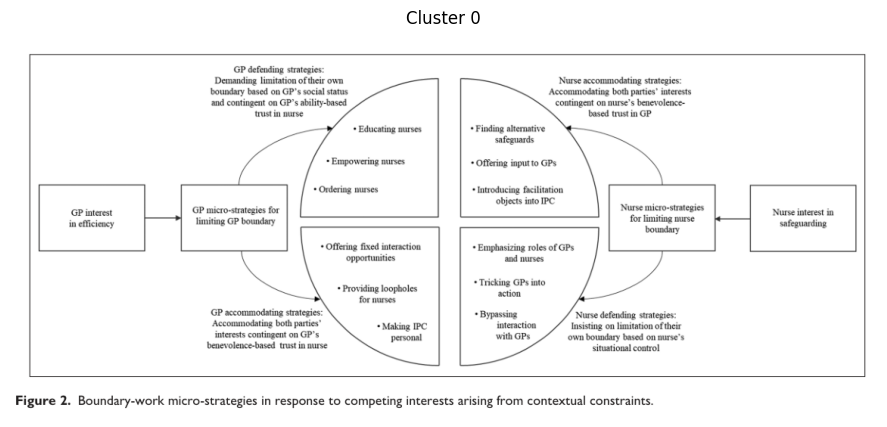

Subcategory,conceptual diagram
Cluster,
0,21


In [8]:
clustering_types = [
   "conceptual diagram",
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
# Create directories for clusters
base_dir = f'../clustered_images/{year}/conceptual diagram'
labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca, cluster_count = 1)
## display closest images
display_closest_images(closest_images, base_dir)
## Show counts of figure types in each cluster
cluster_data = pd.DataFrame({
    'Cluster': labels,
    'Subcategory': subcategories
})
# Create a pivot table to count subcategories in each cluster
subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
subcategory_counts

## Clustering for Data Structure

In [9]:
clustering_types = [
   "data structure",
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
if(current_yearly_data.shape[0] > 8):
    features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
    # Create directories for clusters
    base_dir = f'../clustered_images/{year}/data structure'
    labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca, cluster_count = 1)
    ## display closest images
    display_closest_images(closest_images, base_dir)
    ## Show counts of figure types in each cluster
    cluster_data = pd.DataFrame({
        'Cluster': labels,
        'Subcategory': subcategories
    })
    # Create a pivot table to count subcategories in each cluster
    subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
    subcategory_counts

Figure count in selected subcategories: 5


## Clustering for Cyle

In [10]:
clustering_types = [
   "cycle",
]
current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
print(f"Figure count in selected subcategories: {current_yearly_data.shape[0]}")
if(current_yearly_data.shape[0] > 8):
    features_flattened, pca, image_paths = get_image_variance(current_yearly_data)
    # Create directories for clusters
    base_dir = f'../clustered_images/{year}/process diagram'
    labels, subcategories, closest_images = reduce_create_visualize_save_cluters(current_yearly_data, features_flattened, image_paths, base_dir, pca, cluster_count = 1)
    ## display closest images
    display_closest_images(closest_images, base_dir)
    ## Show counts of figure types in each cluster
    cluster_data = pd.DataFrame({
        'Cluster': labels,
        'Subcategory': subcategories
    })
    # Create a pivot table to count subcategories in each cluster
    subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
    subcategory_counts

Figure count in selected subcategories: 6
